<h1 align="center">Analyzing Brain Connectivity via Projections of Light Microscopy Neurons</h1> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 1: Introduction

The main objective of this notebook is to analyze the whole-brain connectivity of neurons imaged via Light Microscopy (LM). The neurons in this dataset are acquired by imaging the volume of an entire brain wherein a small number of cells are sparsely labelled, and then tracing the axons and dendrites of those cells to reconstruct their full morphologies. Neurons from several brains are integrated by aligning each sample to the Common Coordinate Framework. 



In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

data_root = "/data/"

<div style="text-align: center;">
    <img src='imgs/lm-vs-em.png' style="max-width: 65%; height: auto;">
</div>

<font size="4"><b> Figure 1:</b> LM neuron shown in blue and EM neuron shown in purple.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

As an introduction to analyzing projections of LM neurons, we will explore three questions related to brain connectivity:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 1:</strong> What are the inputs and outputs of a single neuron? </font>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 2:</strong>  What are the population inputs to a specified region?  </font>
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 3:</strong> What are the population outputs to a specified region?

These questions involve analyzing sets of neuronal morphologies to provide a general overview of how neurons connect different brain regions. Neurons integrate inputs at their somas and dendrites, then transmit their outputs via axons. In this tutorial, we'll define connectivity by the presence and number of axon terminals (also referred to as axonal endpoints). We'll refer to hypothetical brain region A being connected to region B if a neuron exists with somatic or dendritic compartments in A, and axon terminals in B. 
We'll address Questions 2 and 3 by querying neurons projecting to and from the mediodorsal nucleus of the thalamus (MD). Note that while each neuron in the LM dataset has been fully reconstructed, by no means does this dataset contain a comprehensive accounting of all neurons in all brain areas. Keep this in mind when formulating your future analyses - failing to observe a connection may reflect a lack of sampling rather than a true lack of connectivity. 
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Brain Region Information:** Neuron morphologies are described by sequences of points or vertices. Every LM neuron within this dataset has been registered to the CCF, so each point will contain metadata describing the region of the brain that point lies within. This metadata is saved as a numerical identifier of that brain region, called a CCF id. We use a python package called `brainglobe_atlasapi` to query information from the CCF ontology (an ontology is a map of the hierarchical relationship between different brain regions). This allows us to go between a CCF region's numerical identifier and other properties such as its full name, acronym, or descendants/ancestors regions. We can extract information about a brain region in the CCF atlas by using a routine called "get_ccf_property". This routine takes a CCF id and some property (e.g. name or acronym) as the inputs, then returns the corresponding information about that CCF id. Next, we'll provide some examples of using this routine.


<div style="text-align: center;">
    <img src='imgs/ccf.png' style="max-width: 65%; height: auto;">
</div>

<font size="4"><b> Figure 2:</b> Sagittal view of Allen Reference Atlas.

In [3]:
#imports for the ccf and brainglobe
from brainglobe_atlasapi import BrainGlobeAtlas
from pprint import pprint
from utils.ccf_utils import get_ccf_property

import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import config
import os
config.write_default_config()

In [5]:
# Load ccf atlas
brain_globe_path = os.path.join(data_root, ".brainglobe")
atlasapi.config.write_config_value('brainglobe_dir', brain_globe_path)
ccf_atlas = BrainGlobeAtlas('allen_mouse_10um')

# Print important data structures in "ccf_atlas"
print("This is a look up table which stores basic information about each structure...\n")
print(ccf_atlas.lookup_df)


# To see the hierarchical structure of the ccf, uncomment the lines below
# print("\n This is the hierarchy of regions stored in the ccf")
# print(ccf_atlas.structures)


This is a look up table which stores basic information about each structure...

    acronym   id                                name
0      root  997                                root
1      grey    8       Basic cell groups and regions
2        CH  567                            Cerebrum
3       CTX  688                     Cerebral cortex
4     CTXpl  695                      Cortical plate
..      ...  ...                                 ...
835      V3  129                     third ventricle
836      AQ  140                   cerebral aqueduct
837      V4  145                    fourth ventricle
838     V4r  153                      lateral recess
839       c  164  central canal, spinal cord/medulla

[840 rows x 3 columns]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<font size="4"> We can extract information about a given region in the ccf by querying from `ccf_atlas.structures`. </font>
    

In [6]:
# Report brain region
ccf_id = 1062
pprint(ccf_atlas.structures[ccf_id])


{'acronym': 'SSp-bfd6b',
 'id': 1062,
 'mesh': None,
 'mesh_filename': PosixPath('/data/.brainglobe/allen_mouse_10um_v1.2/meshes/1062.obj'),
 'name': 'Primary somatosensory area, barrel field, layer 6b',
 'rgb_triplet': [24, 128, 100],
 'structure_id_path': [997, 8, 567, 688, 695, 315, 453, 322, 329, 1062]}


In [8]:
ccf_atlas.get_structure_ancestors(ccf_id)

['root', 'grey', 'CH', 'CTX', 'CTXpl', 'Isocortex', 'SS', 'SSp', 'SSp-bfd']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 2: Accessing neuronal morphology
    
We'll start by loading all of the neurons currently available to us within the LM datasets. </font>

In [126]:
#imports
from utils.ccf_utils import get_ccf_ids
from utils.skeleton_loading_utils import number_of_samples, load_lm_datasets, progress_bar
import skeleton_plot as skelplot

In [127]:
#load full dataset
skel_list = load_lm_datasets(data_root)

Loading datasets...
exaSPIM_609281_2022-11-03_13-49-18_reconstructions/precomputed:  [==================================================] 25/25
exaSPIM_651324_2023-03-06_15-13-25_reconstructions/precomputed:  [==================================================] 13/13
exaSPIM_653158_2023-06-01_20-41-38_reconstructions/precomputed:  [==================================================] 42/42
exaSPIM_653980_2023-08-10_20-08-29_reconstructions/precomputed:  [==================================================] 21/21
mouselight_reconstructions/precomputed:  [==================================================] 1549/1549


In [ ]:
# How many total neurons are contained within these datasets?
len(skel_list)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Inputs/Outputs of a Single Neuron

Our journey to understand how the brain is connected begins with analyzing how a single neuron connects different regions. The purpose of this elementary analysis is to introduce a set of routines that simplify querying information such as finding all neurons with somas in a certain CCF region. We'll begin by choosing a skeleton from our dataset.
    
To start, we need to examine some of the morphological features of a single neuron. We will load the reconstructed skeleton. A precomputed skeleton is a simplified representation of a neuron where its shape is captured by a tree-like structure that passes through the center of the neuron. More specificy, a precomputed skeleton stores a neuron as a graph with vertices and edges in addition to a collection of vertex-attached attributes that capture morphological and anatomical information about the neuron.

    
 Each vertex of the skeleton is an [x,y,z] coordinate. The vertices and their edges form a 'geometric graph'
    
<p> Note: Observe that many attributes such as "radius" and "compartment" have the same shape as "vertices". Each vertex may also be associated with one or more other properties, including:
<ul>
    <li> <code>radius</code>: the estimated cross-section radius of the segment
    <li> <code>compartment</code>: whether the segment belongs to the axon, dendrite, or soma. 
</ul>

<p>We will see these properties rendered later in this notebook, and discuss the other properties synapse properties in later notebooks. 

</div>

In [135]:
skel = skel_list[48]

In [136]:
skel.vertices

array([[6312528.5, 3841441.5, 5461884.5],
       [6321634.5, 3841774.5, 5461032.5],
       [6326855.5, 3840658. , 5461117. ],
       ...,
       [5894479.5, 5066693. , 4897621. ],
       [5868325.5, 5020000. , 4852477.5],
       [5869703.5, 5014931. , 4846610. ]], dtype=float32)

In [137]:
skel.edges

array([[    1,     0],
       [  163,     0],
       [  770,     0],
       ...,
       [12582, 12581],
       [12583, 12582],
       [12585, 12584]])

In [138]:
skel.vertex_properties

{'ccf': array([362, 362, 362, ..., 797, 549, 549]),
 'compartment': array([1, 3, 3, ..., 2, 2, 2]),
 'radius': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
       
**Note about morphological compartments:** The compartment types defined at each vertex adhere to standardized conventions for neuronal morphologies saved as swc files (for more information, see here: <a href="www.neuromorpho.org">www.neuromorpho.org</a>). These conventions are as follows:
    
<ul>
<li> 0 - undefined
<li> 1 - soma
<li> 2 - axon
<li> 3 - (basal) dendrite
<li> 4 - apical dendrite
<li> 5+ - custom
</ul>

In most of these LM neurons, distinctions were not made between basal or apical dendrites - therefore dendrites should almost exclusively map to compartment type "3". 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<p> We can start to put these features together to look at the neuron...
</div>

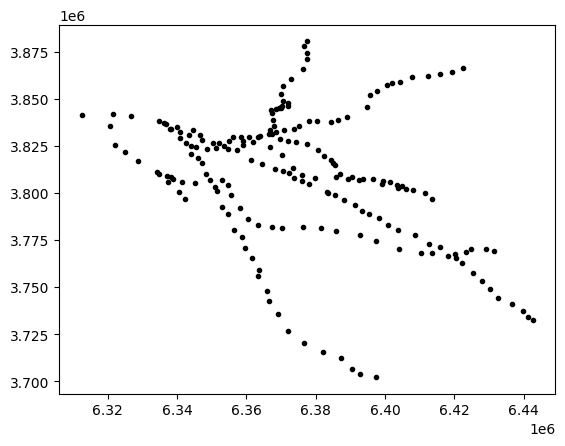

In [147]:
for i in range(200):
    plt.plot(skel.vertices[i,0], skel.vertices[i,1], 'k.')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<p> But that's not an efficient way to look at these neurons. We can use some common tools to visualize the skeleton in both 2D and 3D
</div>

(2094897.25, 6482126.5, 5485209.0, 2436723.5)

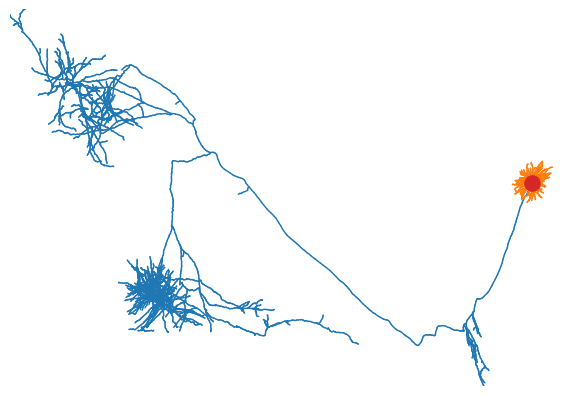

In [139]:
f, ax = plt.subplots(figsize=(7, 7))
skelplot.plot_tools.plot_skel(
    skel,
    line_width=1,
    plot_soma=True,
    invert_y=True,
    pull_compartment_colors=True,
    skel_color_map={0: "tab:green", 1: "tab:red", 2: "tab:blue", 3: "tab:orange"},
    x="x",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')    

In [140]:
# Imports
import k3d
import random
import trimesh
import os

# Define plotting functions to turn a skeleton into line objects
def plot_graphs(graphs, plot, color = None, opacity = 1):
    for i, g in enumerate(graphs):
        if color == None:
            colorstr = "%06x" % random.randint(0, 0xFFFFFF)
            c  = int(colorstr, 16) + 0x200
        elif type(color) == type([]):
            c = color[i]
        else:
            c = color
        plot += graph_to_lines(g,c,opacity)
        
def graph_to_lines(g,color=None, opacity = 1):
    lines = k3d.factory.lines(
        g.vertices,
        g.edges,
        indices_type='segment', 
        width=1, shader='simple',
        color=color,
        opacity=opacity
    )
    return lines

def get_whole_ccf_mesh():
    mesh_path = os.path.join(data_root, "AllenCCFMesh", "MouseBrainAllen3.obj")
    with open(mesh_path) as f:
        return trimesh.load(f, 'obj')

def get_region_ccf_mesh(ccf_id):
    mesh_path = get_ccf_property(ccf_atlas, ccf_id, "mesh_filename")
    try:
        with open(mesh_path) as f:
            return trimesh.load(f, 'obj')
    except:
        print("Mesh does not exist!")


In [141]:
# Generate plot
plot = k3d.plot()
plot_graphs([skel], plot)

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot

# Add region of ccf mesh
soma_ccf_id = get_ccf_ids(ccf_atlas, skel, compartment_type=1)[0]
region_mesh = get_region_ccf_mesh(soma_ccf_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.2)
plot += region_mesh_plot

plot.display()

Output()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"> <p>Where is the soma of this neuron located?
</div>

In [151]:
skel.root

array(0)

In [152]:
pprint(ccf_atlas.structures[skel.vertex_properties['ccf'][0]])

{'acronym': 'MD',
 'id': 362,
 'mesh': None,
 'mesh_filename': PosixPath('/data/.brainglobe/allen_mouse_10um_v1.2/meshes/362.obj'),
 'name': 'Mediodorsal nucleus of thalamus',
 'rgb_triplet': [255, 144, 159],
 'structure_id_path': [997, 8, 343, 1129, 549, 856, 444, 362]}


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<p> We have a convenience function to access the ccf location of different features called `get_ccf_ids`

In [153]:
soma_ccf = get_ccf_ids(ccf_atlas, skel, compartment_type=1) 
print("Soma is in the", get_ccf_property(ccf_atlas, soma_ccf[0], "name"))

Soma is in the Mediodorsal nucleus of thalamus


In [154]:
# We can also query particular vertex types, e.g. end_points or branch_points. 
dendrite_endpoints_ccf = get_ccf_ids(ccf_atlas, skel, compartment_type=3, vertex_type="end_points")

In [155]:
for ccfid in np.unique(dendrite_endpoints_ccf):
    if ccfid>0:
        print(str(len(np.where(dendrite_endpoints_ccf==ccfid)[0])) + " dendrite endpoints in " + ccf_atlas.structures[ccfid]["name"])

95 dendrite endpoints in Mediodorsal nucleus of thalamus


In [156]:
# Define:  axon_endpoints_ccf
axon_endpoints_ccf = get_ccf_ids(ccf_atlas, skel, compartment_type=2, vertex_type="end_points")

for ccfid in np.unique(axon_endpoints_ccf):
    if ccfid>0:
        print(str(len(np.where(axon_endpoints_ccf==ccfid)[0])) + " axon endpoints in " + ccf_atlas.structures[ccfid]["name"])

1 axon endpoints in Prelimbic area, layer 6a
1 axon endpoints in Agranular insular area, posterior part, layer 2/3
34 axon endpoints in Prelimbic area, layer 1
2 axon endpoints in Lateral hypothalamic area
9 axon endpoints in Prelimbic area, layer 2/3
52 axon endpoints in Agranular insular area, dorsal part, layer 2/3
11 axon endpoints in Bed nuclei of the stria terminalis
3 axon endpoints in Prelimbic area, layer 5
51 axon endpoints in Orbital area, medial part, layer 1
5 axon endpoints in Thalamus
1 axon endpoints in Infralimbic area, layer 2/3
11 axon endpoints in Orbital area, medial part, layer 2/3
2 axon endpoints in Orbital area, medial part, layer 5
1 axon endpoints in Caudoputamen
46 axon endpoints in Agranular insular area, ventral part, layer 2/3
19 axon endpoints in Agranular insular area, ventral part, layer 1
3 axon endpoints in Infralimbic area, layer 1
5 axon endpoints in Zona incerta
25 axon endpoints in Agranular insular area, ventral part, layer 5
4 axon endpoints in

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 3: Analyzing the Inputs to a Brain Region
    
<font size="4"> </font>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Inputs to a Brain Region
    
<font size="4"> Now, let's use our newfound skills to answer our first question for this tutorial: </font>

<font size="4"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 1:</strong> What do the inputs to a particular brain region look like? </font>
    
<font size="4"> We'll do so by formulating two queries: </font>
    
<font size="4"><strong> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Query 1:</strong> Find all neurons with axon endpoints in a given brain region. </font>
    
<font size="4"><strong> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Query 2:</strong> Given these neurons, find which regions their somas reside in. </font>  

<font size="4"> For today's exercise we'll look at the mediodorsal nucleus of thalamus or MD. This is a non-sensory thalamic nucleus thought to be involved in cognitive processes such as decision-making and working memory. Historically, prefrontal cortex has been defined as the cortical region with reciprocal connectivity with MD. We'll examine some of the diverse inputs this thalamic nucleus receives. </font>

In [158]:
target_ccf_id = ccf_atlas.structures['MD']['id']
print(target_ccf_id)

362


In [201]:
# Search for skeletons with axon end points in our target structure
skels_subset = []
for i, skel in enumerate(skel_list):
    progress_bar(i + 1, len(skel_list))
    if target_ccf_id in set(get_ccf_ids(ccf_atlas, skel, compartment_type=2, vertex_type="end_points")):
        skels_subset.append(skel)

print("\n# Skeletons Found:", len(skels_subset))

[==================================================] 1650/1650
# Skeletons Found: 167


In [160]:
# Let's look at all these neurons
plot = k3d.plot()
plot_graphs(skels_subset, plot, opacity=0.2)  #we have many neurons to plot so we'll reduce their opacity here

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot

# Add region of ccf mesh
region_mesh = get_region_ccf_mesh(target_ccf_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.2)
plot += region_mesh_plot

plot.display()

Output()

In [202]:
# -- Query 2 --
# i.e. Given these neurons, where are these neuron's somas?

# Get regions
ccf_ids_list = list()
for skel in skels_subset:
    ccf_ids_list.extend(
        get_ccf_ids(ccf_atlas, 
        skel,
        compartment_type=1
        )
    )

# Count each region occurrence
ccf_ids, cnts = np.unique(ccf_ids_list, return_counts=True)
print("# Distinct Regions Found:", len(ccf_ids))

# Distinct Regions Found: 47


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<font size='4'> To finish answering what the inputs to a brain region look like, let's generate a bar plot of the brain regions that we queried.

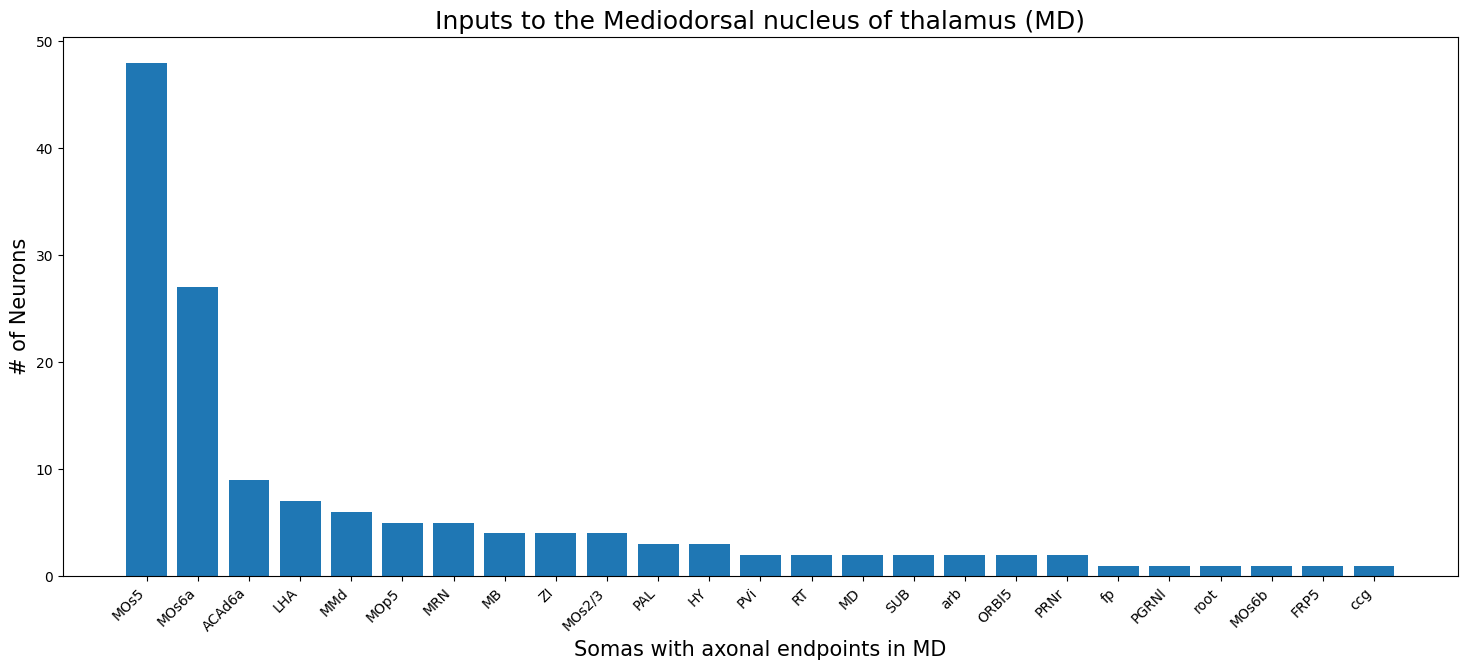

In [203]:

cnts_sort = cnts[np.argsort(cnts)[::-1]][:25]
ids_sort = ccf_ids[np.argsort(cnts)[::-1]][:25]

# Get brain region names
ccf_names = list()
for ccf_id in ids_sort:
    acronym = ccf_atlas.structures[ccf_id]['acronym']
    ccf_names.append(acronym)
    
# Make plot
plt.figure(figsize=(18, 7))
plt.bar(ccf_names, cnts_sort)
plt.xticks(rotation=45, ha='right')
#plt.yscale('log')

# Add titles and labels
plt.title("Inputs to the Mediodorsal nucleus of thalamus (MD)", fontsize=18)
plt.xlabel("Somas with axonal endpoints in MD", fontsize=15)
plt.ylabel("# of Neurons", fontsize=15)

# Show the plot
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 4: Analyzing divergent information flow : Population Study
    
<font size='4'> We've now looked at a few of the diverse inputs to MD. How is this information integrated and distributed to the rest of the brain? Physiological experiments are best suited for interrogating how information is transformed across synapses. However morphological analysis can cue us into the output channels of the MD circuit. Do all MD neurons uniformly target the same brain structures, or is there diversity in their projection patterns? One way to formalize this question is with clustering analysis.
    
<font size="4"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 3:</strong> Are neuronal morphologies stereotyped, or are there distinct projection classes?


In [169]:
target_ccf_id

362

In [170]:
# Search for skeletons with somas in our target structure
skels_subset = []
for i, skel in enumerate(skel_list):
    progress_bar(i + 1, len(skel_list))
    if target_ccf_id in set(get_ccf_ids(ccf_atlas, skel, compartment_type=1)):
        skels_subset.append(skel)

print("\n# Skeletons Found:", len(skels_subset))

[==================================================] 1650/1650
# Skeletons Found: 21


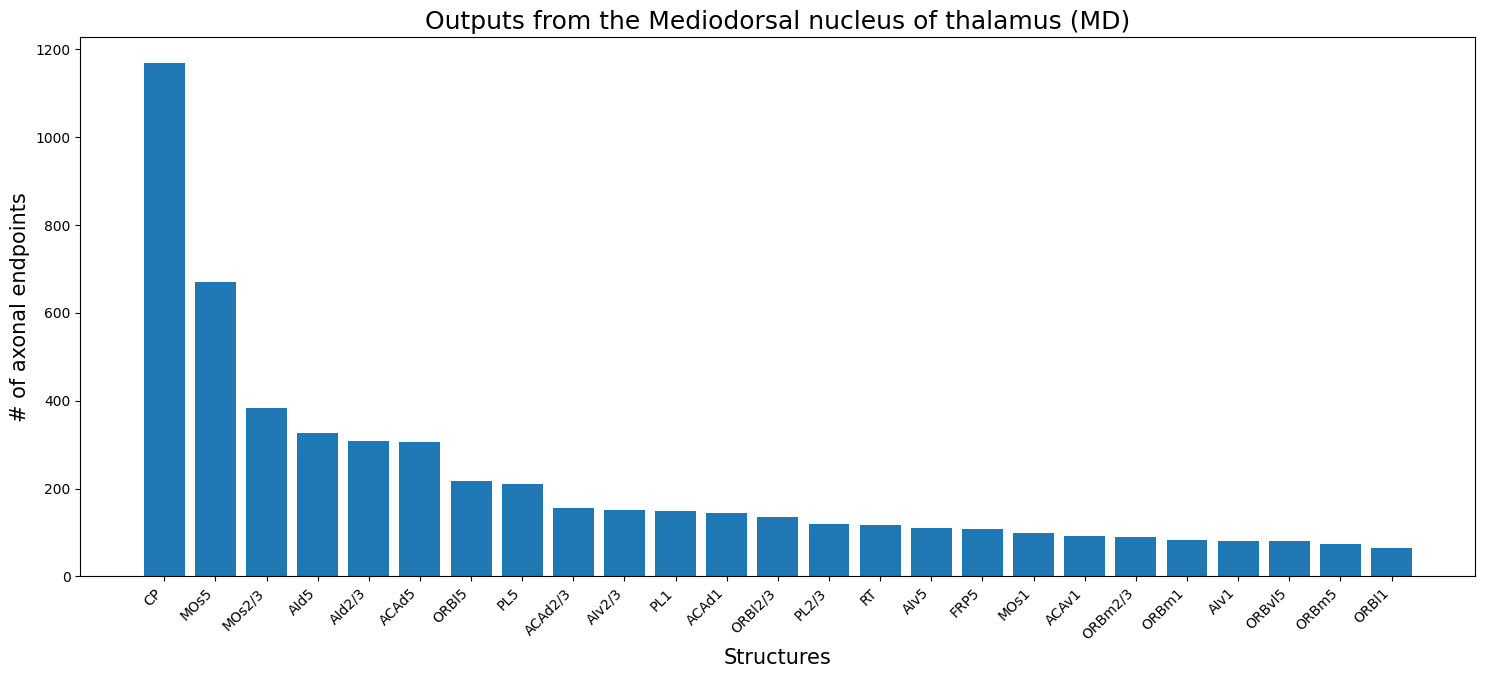

In [198]:
# First lets look at the projection targets of our population of neurons. We'll collect CCF endpoints:
axon_endpoints_ccf = list()
for skel in skels_subset:
    axon_endpoints_ccf.extend(get_ccf_ids(ccf_atlas, skel, compartment_type=2, vertex_type="end_points"))

axon_endpoints_ccf = [x for x in axon_endpoints_ccf if ~np.isnan(x)]

# Then we'll plot the total axonal endpoints of our population of neurons. To reduce visual clutter, we'll only plot the top 25 most targeted CCF structures.
n_structures_to_plot = 25
ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True)

cnts_sort = cnts[np.argsort(cnts)[::-1]][:25]
ids_sort = ids[np.argsort(cnts)[::-1]][:25]

# Get brain region names
ccf_names = list()
for ccf_id in ids_sort:
    if ccf_id>0:
        acronym = ccf_atlas.structures[ccf_id]['acronym']
        ccf_names.append(acronym)
    else:
        ccf_names.append('NaN')
    
# Make plot
plt.figure(figsize=(18, 7))
plt.bar(ccf_names, cnts_sort)
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')

# Add titles and labels
plt.title("Outputs from the Mediodorsal nucleus of thalamus (MD)", fontsize=18)
plt.xlabel("Structures", fontsize=15)
plt.ylabel("# of axonal endpoints", fontsize=15)

# Show the plot
plt.show()